<center>
  <h1>GEOM90006 A4 Final </h1>
  <h2>Yongjie Yan | Bolang Yu</h2>
  <h3>Analysing the Impact of Rainfall Variability on Traffic Crashes Across Local Government Areas in Victoria</h3>
</center>



### Introduction 
Understanding the relationship between weather conditions, particularly rainfall, and traffic crashes is critical for improving road safety. Previous studies have highlighted the significant impact of rainfall on accident rates. For instance, Jaroszweski and McNamara (2014) found that rainfall significantly increased the rate of road accidents in urban areas of Manchester and Greater London. Similarly, Eck et al. (2022) demonstrated that the risk of traffic crashes in the Carolinas increased substantially with higher rainfall intensity, particularly during morning rush hours and winter. Khan et al. (2008) used spatial statistical techniques to identify weather-related crash patterns in Wisconsin, emphasizing the importance of spatial analysis in understanding these relationships.

Building on these insights, our study aims to explore the correlation between rainfall and car crashes across different LGAs in Victoria, Australia. We hypothesize that the LGA with the highest crash rate also experiences the highest rainfall. Our research question is: '**How does rainfall variability affect the frequency and severity of traffic crashes in different LGAs in Victoria?** ' By analyzing car crash data and rainfall data, we aim to identify potential risk areas and provide evidence-based recommendations for traffic safety measures. The expected outcome of our research is a set of detailed maps showing the spatial distribution of car crashes and rainfall, along with statistical analyses to determine the strength of the correlation between these variables. Our hypothesis is that LGAs with higher rainfall will also exhibit higher crash rates, highlighting the importance of implementing targeted safety measures in these areas. 

### Data Sources:
There are three types of data has been used in this study. 

* Car Crash Data (Point Data): Sourced from the Victorian Road Crash Data provided by the Department of Transport.
* Rainfall Data (Raster Data): Historical rainfall gauge data from the Bureau of Meteorology.
* LGA Data (Polygon Data): Obtained from Data.gov.au to determine the spatial relations of car accidents within LGAs.

### Scope: 

* Geographic Area: The entire state of Victoria, Australia.
* Spatial Scale: Regional level analysis to compare different LGAs within Victoria.
* Time Scope: The study will focus on car crash data from the year 2022 and long-term rainfall data to ensure a comprehensive analysis of the relationship between rainfall and car crashes over a relevant period.

## Datasets description + ESDA
### Point Dataset preprocessing and visualization

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio.warp
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
import math
import rasterio.crs
import warnings
import rasterio

warnings.filterwarnings('ignore')

In [2]:
# Read data
car_carsh_gdf = gpd.read_file('data/Victorian_Road_Crash_Data.geojson')
car_carsh_gdf.head()

,OBJECTID,ACCIDENT_NO,ACCIDENT_TYPE,DAY_OF_WEEK,DCA_CODE,LIGHT_CONDITION,POLICE_ATTEND,ROAD_GEOMETRY,SEVERITY,SPEED_ZONE,...,MOTORCYCLE,PUBLICVEHICLE,DEG_URBAN_NAME,SRNS,RMA,DIVIDED,STAT_DIV_NAME,Accident_Date,Accident_Time,geometry
0,1,T20120000009,Collision with a fixed object,Sunday,LEFT OFF CARRIAGEWAY INTO OBJECT/PARKED VEHICLE,Dark No street lights,Yes,Not at intersection,Other injury accident,100 km/hr,...,0.0,None,RURAL_VICTORIA,C,Arterial Other,Undivided,Country,1/01/2012,02:25:00,POINT (145.72671 -38.23494)
1,2,T20120000012,Collision with vehicle,Sunday,CROSS TRAFFIC(INTERSECTIONS ONLY),Dark Street lights on,Yes,Cross intersection,Serious injury accident,80 km/hr,...,0.0,None,MELB_URBAN,None,Arterial Highway,Divided,Metro,1/01/2012,02:00:00,POINT (145.16141 -37.90353)
2,3,T20120000013,Collision with vehicle,Sunday,VEHICLE COLLIDES WITH VEHICLE PARKED ON LEFT O...,Dark Street lights on,Yes,T intersection,Serious injury accident,60 km/hr,...,0.0,None,MELB_URBAN,None,Arterial Other,Undivided,Metro,1/01/2012,03:35:00,POINT (145.09885 -37.93593)
3,4,T20120000018,Collision with a fixed object,Sunday,RIGHT OFF CARRIAGEWAY INTO OBJECT/PARKED VEHICLE,Dark No street lights,Yes,Cross intersection,Other injury accident,100 km/hr,...,0.0,None,RURAL_VICTORIA,A,Arterial Highway,Undivided,Country,1/01/2012,05:15:00,POINT (142.04389 -34.21586)
4,5,T20120000021,Collision with a fixed object,Sunday,LEFT OFF CARRIAGEWAY INTO OBJECT/PARKED VEHICLE,Day,Yes,Not at intersection,Other injury accident,50 km/hr,...,0.0,None,MELB_URBAN,None,Local Road,Undivided,Metro,1/01/2012,07:30:00,POINT (144.77794 -38.36955)


In [3]:
# Filter out the useful columns
car_carsh_prep = car_carsh_gdf[['ACCIDENT_TYPE','LIGHT_CONDITION', 'SEVERITY','DEG_URBAN_NAME', 'Accident_Date', 'geometry']]
car_carsh_prep.head(10)

,ACCIDENT_TYPE,LIGHT_CONDITION,SEVERITY,DEG_URBAN_NAME,Accident_Date,geometry
0,Collision with a fixed object,Dark No street lights,Other injury accident,RURAL_VICTORIA,1/01/2012,POINT (145.72671 -38.23494)
1,Collision with vehicle,Dark Street lights on,Serious injury accident,MELB_URBAN,1/01/2012,POINT (145.16141 -37.90353)
2,Collision with vehicle,Dark Street lights on,Serious injury accident,MELB_URBAN,1/01/2012,POINT (145.09885 -37.93593)
3,Collision with a fixed object,Dark No street lights,Other injury accident,RURAL_VICTORIA,1/01/2012,POINT (142.04389 -34.21586)
4,Collision with a fixed object,Day,Other injury accident,MELB_URBAN,1/01/2012,POINT (144.77794 -38.36955)
5,Collision with a fixed object,Dark No street lights,Serious injury accident,RURAL_VICTORIA,1/01/2012,POINT (145.64318 -37.01844)
6,Struck Pedestrian,Dark Street lights on,Other injury accident,MELB_URBAN,1/01/2012,POINT (144.95323 -37.84172)
7,Collision with vehicle,Dark No street lights,Serious injury accident,MELB_URBAN,1/01/2012,POINT (145.28837 -38.12146)
8,Collision with vehicle,Day,Serious injury accident,MELB_URBAN,1/01/2012,POINT (145.35642 -37.93456)
9,Struck Pedestrian,Day,Other injury accident,MELB_URBAN,1/01/2012,POINT (144.87756 -38.36716)


In [4]:
# Output basic information
# Convert 'Accident_Date' to datetime
car_carsh_prep['Accident_Date'] = pd.to_datetime(car_carsh_prep['Accident_Date'], format='%d/%m/%Y', errors='coerce')
print('Number of rows:', car_carsh_prep.shape[0],'First date:', car_carsh_prep['Accident_Date'].min().date(), 'Last date:', car_carsh_prep['Accident_Date'].max().date())

# Retrieve data for 2022
crash_data_2022 = car_carsh_prep[(car_carsh_prep['Accident_Date'] >= '2022-01-01') & (car_carsh_prep['Accident_Date'] <= '2022-12-31')]
print('Number of rows:', car_carsh_prep.shape[0],'First date:', car_carsh_prep['Accident_Date'].min().date(), 'Last date:', car_carsh_prep['Accident_Date'].max().date())

Number of rows: 165809 First date: 2012-01-01 Last date: 2023-08-31
Number of rows: 165809 First date: 2012-01-01 Last date: 2023-08-31


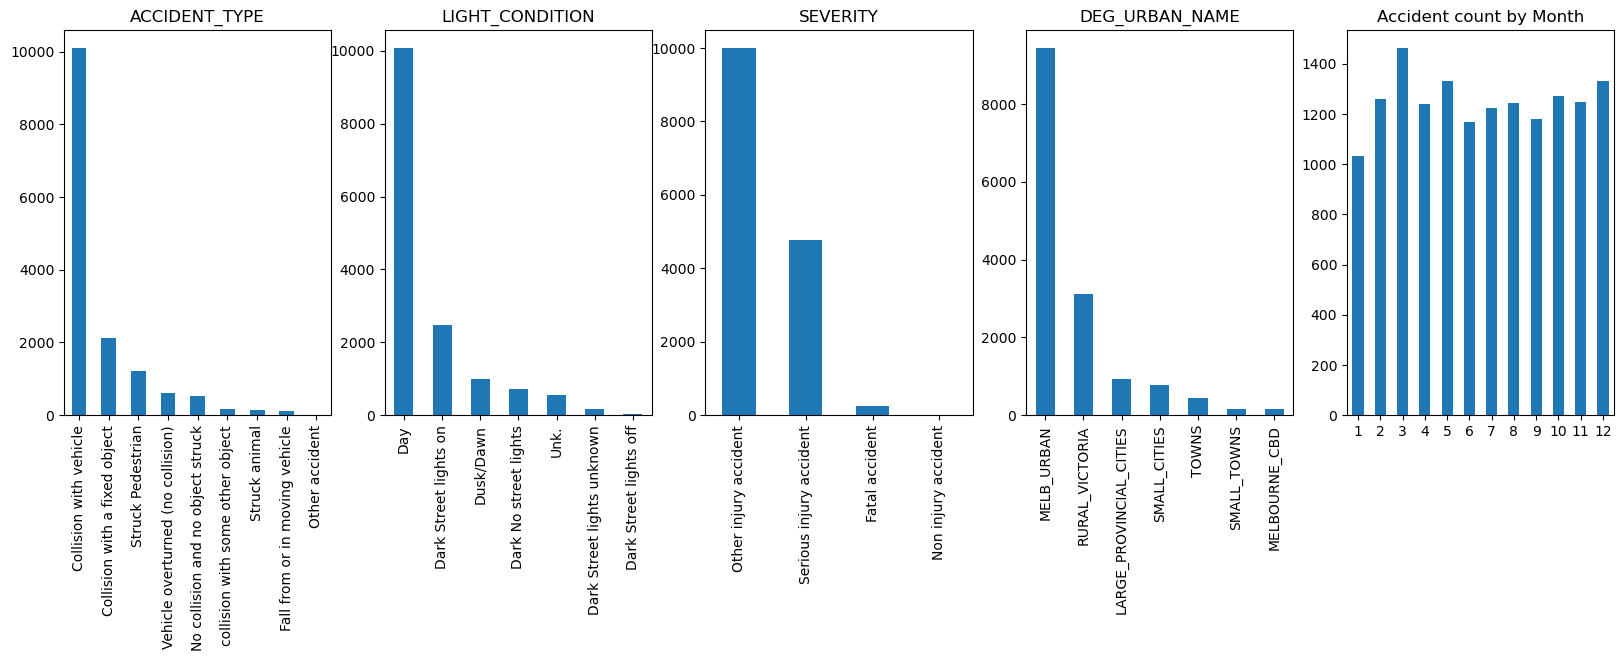

In [5]:
# Plot 'ACCIDENT_TYPE','LIGHT_CONDITION', 'SEVERITY','DEG_URBAN_NAME', 'Accident_Date'
fx, axes = plt.subplots(1, 5, figsize=(20, 5))
crash_data_2022['ACCIDENT_TYPE'].value_counts().plot(kind='bar', ax=axes[0], title='ACCIDENT_TYPE', xlabel='')
crash_data_2022['LIGHT_CONDITION'].value_counts().plot(kind='bar', ax=axes[1], title='LIGHT_CONDITION', xlabel='')
crash_data_2022['SEVERITY'].value_counts().plot(kind='bar', ax=axes[2], title='SEVERITY', xlabel='')
crash_data_2022['DEG_URBAN_NAME'].value_counts().plot(kind='bar', ax=axes[3], title='DEG_URBAN_NAME', xlabel='')
crash_data_2022['Accident_Date'].dt.month.value_counts().sort_index().plot(kind='bar', ax=axes[4], title='Accident count by Month',rot = 0, xlabel='')
# plt.xticks(rotation=45)
plt.show()

The above analysis of car crash data has reveals several notable trends. The most frequent type of accident is a collision with another vehicle, significantly outnumbering other types like collisions with fixed objects and pedestrian strikes.

 Most accidents occur during the day, with significantly fewer incidents happening under various night-time conditions. This may be due to the lower traffic volume at night time. Regarding severity, the majority of accidents are categorized as "Other injury accidents," followed by serious and fatal accidents. 
 
 Geographically, Melbourne Urban records the highest number of accidents, with Rural Victoria and large provincial cities also experiencing significant numbers. The distribution of accidents across the months shows relative consistency, with a slight peak in March, which we could focus on the rainfall data to see if March also has the highest rainfall volume. January has the lowest number of accidents, which could be due to people were still on vacation in early January. Hence, the traffic volume was lower compared to other months. 
 
 These findings suggest that traffic volume, particularly during daytime in urban areas, is a critical factor for accident occurrence. 

### Polygon data: LGA boundaries in Victoria
Our polygon dataset contains the boundaries of Local Government Areas (LGAs) in Victoria. We will combine this dataset with the above car crash data to analyze traffic accident occurrences in different regions.

In [6]:
# Read data
lgas_path = 'data/vic_lga.shp'
victoria_state = gpd.read_file(lgas_path)

In [7]:
# Initialize the crash_count and crash_severity columns in the victoria_state DataFrame
victoria_state['crash_count'] = 0
victoria_state['crash_severity'] = [[0] for i in range(len(victoria_state))]

# Iterate over each row in the victoria_state DataFrame
for index, row in victoria_state.iterrows():
    # Add crash counts and severity scores to regions in victoria_state if points are within the region's geometry
    for index2, row2 in crash_data_2022.iterrows():
        if row['geometry'].contains(row2['geometry']):
            victoria_state.at[index, 'crash_count'] += 1 # Increment the crash count

            # Fatal accident
            # Serious injury accident
            # Other injury accident
            # Non injury accident
            
            # Increase the severity score based on the severity of the accident
            if row2['SEVERITY'] == 'Fatal accident':
                victoria_state.at[index, 'crash_severity'] += [16]
            elif row2['SEVERITY'] == 'Serious injury accident':
                victoria_state.at[index, 'crash_severity'] += [8]
            elif row2['SEVERITY'] == 'Other injury accident':
                victoria_state.at[index, 'crash_severity'] += [2]
            elif row2['SEVERITY'] == 'Non injury accident':
                victoria_state.at[index, 'crash_severity'] += [1]

In [8]:
# Compute severity: if there's only one value, use that value, otherwise compute the average
victoria_state['crash_severity'] = victoria_state['crash_severity'].apply(lambda x: np.mean(x[1:]) if len(x) > 1 else x[0])
# victoria_state['crash_severity'] = victoria_state['crash_severity'].apply(lambda x: np.mean(x[1:]))
victoria_state.head()

,LG_PLY_PID,LGA_PID,DT_CREATE,LGA_NAME,ABB_NAME,STATE,geometry,crash_count,crash_severity
0,lgpKRtJNYEope2S,lga136d886cbd2c,2023-08-11,Alpine Shire,Alpine,VIC,"POLYGON ((147.32088 -37.02310, 147.32117 -37.0...",51,4.823529
1,lgpn94vPvfWl_Lk,lga48c76dfa462e,2024-02-12,Ararat Rural City,Ararat,VIC,"POLYGON ((142.41912 -37.47344, 142.41892 -37.4...",40,4.750000
2,lgpCSlOKZhanGA6,lgab70a9914e5bc,2023-11-12,Ballarat City,Ballarat,VIC,"POLYGON ((143.84322 -37.67027, 143.84304 -37.6...",299,3.872910
3,lgpM0UMGpTebStd,lga5591321694d6,2023-08-11,Banyule City,Banyule,VIC,"POLYGON ((145.02805 -37.76410, 145.02789 -37.7...",210,3.533333
4,lgp4a-QMAzHOXUL,lgaac2e88625ea2,2023-11-12,Bass Coast Shire,Bass Coast,VIC,"POLYGON ((145.33295 -38.49950, 145.33317 -38.4...",0,0.000000


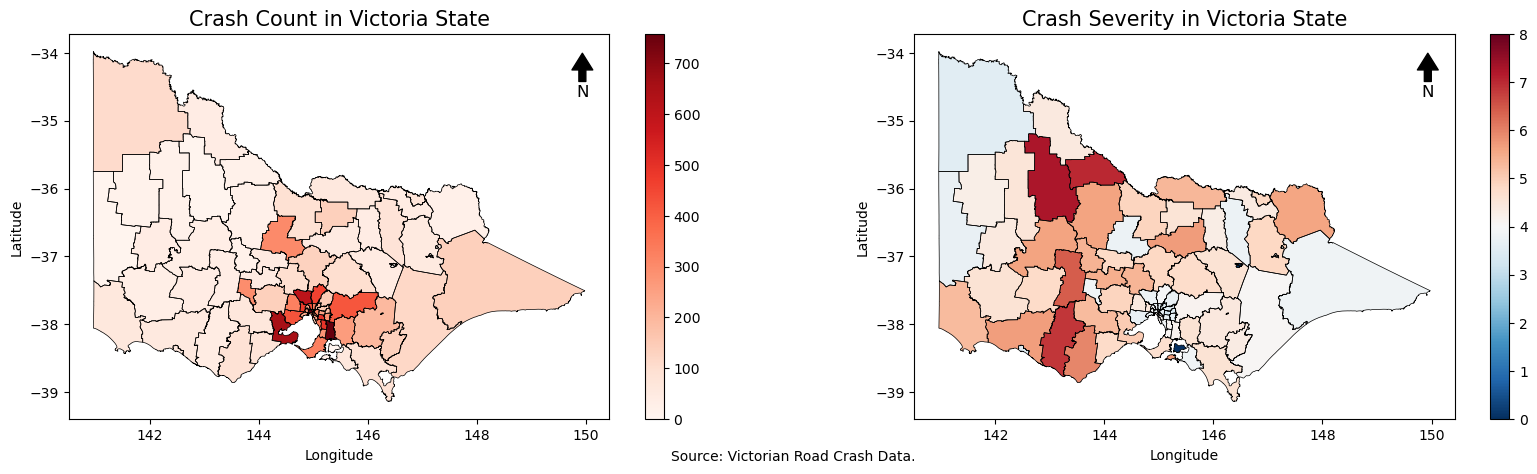

Top 10 LGAs with the most crashes:
['Casey City', 'Melbourne City', 'Greater Geelong City', 'Hume City', 'Monash City', 'Greater Dandenong City', 'Brimbank City', 'Whittlesea City', 'Merri-Bek City', 'Wyndham City']
Top 10 LGAs with the most severe crashes:
['Queenscliffe Borough', 'Buloke Shire', 'Gannawarra Shire', 'Corangamite Shire', 'Pyrenees Shire', 'Colac Otway Shire', 'Strathbogie Shire', 'Bass Coast Shire', 'Moyne Shire', 'Loddon Shire']


In [9]:
# Visualize crash_count and crash_severity
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
# victoria_state.plot(column = 'crash_count',cmap = 'Reds',legend=True)
fx, axes = plt.subplots(1, 2, figsize=(20, 5))
victoria_state.plot(column='crash_count', cmap='Reds', legend=True, ax=axes[0])
axes[0].set_title('Crash Count in Victoria State', fontsize=15)
axes[0].set_facecolor('white')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
# Add borders
victoria_state.boundary.plot(ax=axes[0], color='black', linewidth=0.5)
victoria_state.plot(column='crash_severity', cmap='RdBu_r', legend=True, ax=axes[1])

axes[1].set_title('Crash Severity in Victoria State', fontsize=15)
axes[1].set_facecolor('white')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
victoria_state.boundary.plot(ax=axes[1], color='black', linewidth=0.5)
# Adding the north arrow
x, y, arrow_length = 0.95, 0.95, 0.1
axes[0].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=12, xycoords=axes[0].transAxes)

axes[1].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=12, xycoords=axes[1].transAxes)
fx.text(0.5, 0.02, 'Source: Victorian Road Crash Data. ', ha='center', va='bottom', fontsize=10)
plt.show()

# Output the top 10 most crashed areas
victoria_state_sorted = victoria_state.sort_values(by='crash_count', ascending=False)
print('Top 10 LGAs with the most crashes:')
print(list(victoria_state_sorted.head(10)['LGA_NAME']))
# Output the top 10 most serious areas for crashes
victoria_state_sorted = victoria_state.sort_values(by='crash_severity', ascending=False)
print('Top 10 LGAs with the most severe crashes:')
print(list(victoria_state_sorted.head(10)['LGA_NAME']))


The statistics of crash count and crash severity:
count     92.000000
mean     162.989130
std      179.596097
min        0.000000
25%       35.000000
50%       88.000000
75%      264.750000
max      758.000000
Name: crash_count, dtype: float64
count    92.000000
mean      4.122145
std       1.576320
min       0.000000
25%       3.743386
50%       4.209433
75%       4.827107
max       8.000000
Name: crash_severity, dtype: float64


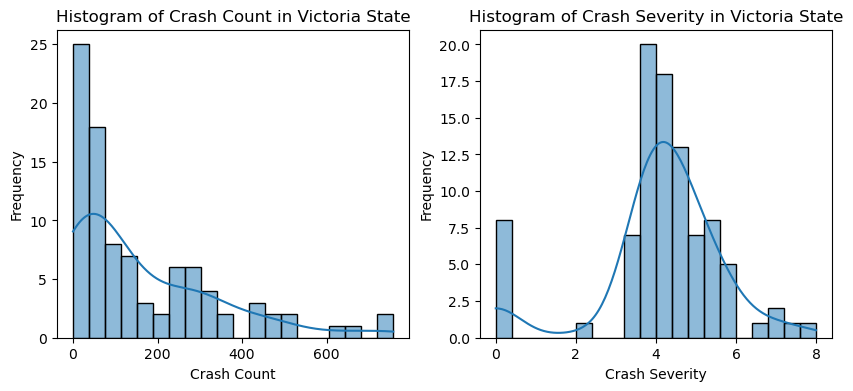

In [10]:
# Plot crash count and crash severity
import seaborn as sns
print('The statistics of crash count and crash severity:')
print(victoria_state['crash_count'].describe())
print(victoria_state['crash_severity'].describe())

fig, ax = plt.subplots(1,2,figsize=(10, 4))
sns.histplot(victoria_state['crash_count'], bins=20, kde=True, ax=ax[0])
ax[0].set_title('Histogram of Crash Count in Victoria State')
ax[0].set_xlabel('Crash Count')
ax[0].set_ylabel('Frequency')
ax[0].set_facecolor('white')

sns.histplot(victoria_state['crash_severity'], bins=20, kde=True, ax=ax[1])
ax[1].set_title('Histogram of Crash Severity in Victoria State')
ax[1].set_xlabel('Crash Severity')
ax[1].set_ylabel('Frequency')
ax[1].set_facecolor('white')

plt.show()

The summarized data indicates significant spatial variations in the distribution of crash counts and severity levels across Victoria. The histogram of crash counts shows a right-skewed distribution, with an average of 162.98 and a standard deviation of 179.60, indicating that most regions have relatively low crash counts, with a few areas experiencing higher numbers. The histogram of crash severity shows an approximately normal distribution with an average severity of 4.12 and a standard deviation of 1.58, suggesting that most crashes cluster around moderate severity levels with fewer extreme values. 

In [11]:
from libpysal.weights import Queen
from esda.moran import Moran
import warnings
warnings.filterwarnings('ignore')

# Create a spatial weights object
w = Queen.from_dataframe(victoria_state)

# Calculate Moran's I
moran_severity = Moran(victoria_state['crash_severity'], w)
moran_count = Moran(victoria_state['crash_count'], w)

print('Moran\'s I for crash severity: ', moran_severity.I)
print('Expected I for crash severity: ', moran_severity.EI)
print('p-value for crash severity: ', moran_severity.p_sim)

print('Moran\'s I for crash count: ', moran_count.I)
print('Expected I for crash count: ', moran_count.EI)
print('p-value for crash count: ', moran_count.p_sim) 


('WARNING: ', 4, ' is an island (no neighbors)')
('WARNING: ', 6, ' is an island (no neighbors)')
('WARNING: ', 23, ' is an island (no neighbors)')
('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 25, ' is an island (no neighbors)')
('WARNING: ', 26, ' is an island (no neighbors)')
Moran's I for crash severity:  0.2963297210016538
Expected I for crash severity:  -0.01098901098901099
p-value for crash severity:  0.002
Moran's I for crash count:  0.5182856925027933
Expected I for crash count:  -0.01098901098901099
p-value for crash count:  0.001


The results indicate significant spatial autocorrelation in both crash severity and crash count within the study area. For crash severity, Moran's I value is 0.296, with a p-value of 0.002, suggesting strong spatial autocorrelation, meaning that areas with high crash severity are likely to be near other areas also has high severity. Similarly, for the crash count, Moran's I value is 0.518, with a p-value of 0.001, also indicating strong spatial autocorrelation. 

These results imply that crash counts and severity levels are not randomly distributed but rather to have spatial clustering within the study region. This result has helped us to understand the geographic patterns of traffic incidents. 

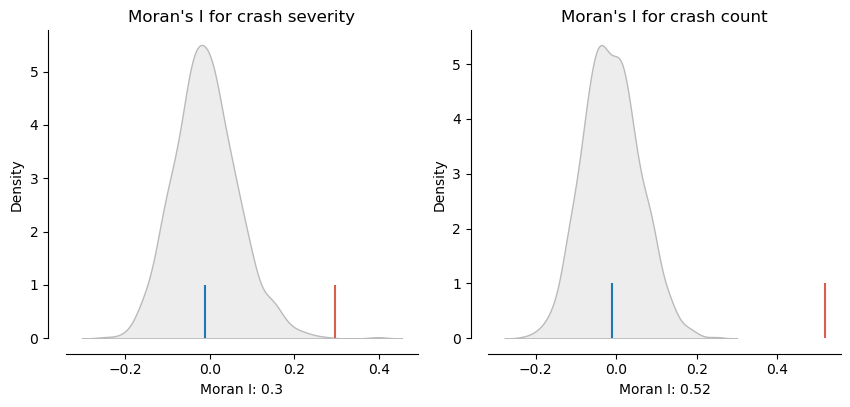

In [12]:
from splot.esda import plot_moran
from splot._viz_esda_mpl import plot_moran_simulation

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_moran_simulation(moran_severity, aspect_equal=False, ax=ax[0])
ax[0].set_title('Moran\'s I for crash severity')
plot_moran_simulation(moran_count, aspect_equal=False, ax=ax[1])
ax[1].set_title('Moran\'s I for crash count')
plt.show()

From the density plots of Moran's I values for crash severity and crash count we can see significant spatial autocorrelation. The observed Moran's I values (0.3 for crash severity and 0.52 for crash count) are substantially higher than what would be expected under a random normal distribution, as illustrated by the density curves. This again suggests that the spatial patterns of crash severity and crash count are not random but exhibit a notable degree of spatial clustering. Reinforce the need for spatially targeted safety interventions to address the areas with higher crash frequencies and severities.

### Raster data: Rainfall in Victoria
Our Raster data contain the rainfall data in Victoria, we will combine this data with the above Polygon data to analysis the rainfall based on different LGAs. 


In [14]:
import rioxarray
# Read data
bom_ras = rioxarray.open_rasterio('data/Victoria rainfall grid.asc', masked=True)

In [15]:
from shapely.geometry import Point

# Retrieve the values from the bom_ras raster and replace any NaN values with 0
values = bom_ras.values
values[np.isnan(values)] = 0

# Initialize the rainfall column in the victoria_state DataFrame
victoria_state['rainfall'] = [ [0] for i in range(len(victoria_state)) ]

# Add rainfall values to regions in victoria_state if points are within the region's geometry
for i in range(len(bom_ras.x)):
    for j in range(len(bom_ras.y)):
        for index, row in victoria_state.iterrows():
            point = Point(bom_ras.x[i].item(), bom_ras.y[j].item())
            # print(type(row['geometry']), type(gpd.points_from_xy(bom_ras.x[i].item(), bom_ras.y[j].item())))
            if row['geometry'].contains(point):
                victoria_state.at[index, 'rainfall'] += [values[0][j][i]]
                # print(victoria_state.at[index, 'rainfall'])

victoria_state['rainfall'] = victoria_state['rainfall'].apply(lambda x: np.mean(x[1:]) if len(x) > 1 else x[0])
victoria_state.head()

,LG_PLY_PID,LGA_PID,DT_CREATE,LGA_NAME,ABB_NAME,STATE,geometry,crash_count,crash_severity,rainfall
0,lgpKRtJNYEope2S,lga136d886cbd2c,2023-08-11,Alpine Shire,Alpine,VIC,"POLYGON ((147.32088 -37.02310, 147.32117 -37.0...",51,4.823529,1377.256592
1,lgpn94vPvfWl_Lk,lga48c76dfa462e,2024-02-12,Ararat Rural City,Ararat,VIC,"POLYGON ((142.41912 -37.47344, 142.41892 -37.4...",40,4.750000,612.444336
2,lgpCSlOKZhanGA6,lgab70a9914e5bc,2023-11-12,Ballarat City,Ballarat,VIC,"POLYGON ((143.84322 -37.67027, 143.84304 -37.6...",299,3.872910,693.364197
3,lgpM0UMGpTebStd,lga5591321694d6,2023-08-11,Banyule City,Banyule,VIC,"POLYGON ((145.02805 -37.76410, 145.02789 -37.7...",210,3.533333,694.495544
4,lgp4a-QMAzHOXUL,lgaac2e88625ea2,2023-11-12,Bass Coast Shire,Bass Coast,VIC,"POLYGON ((145.33295 -38.49950, 145.33317 -38.4...",0,0.000000,0.000000


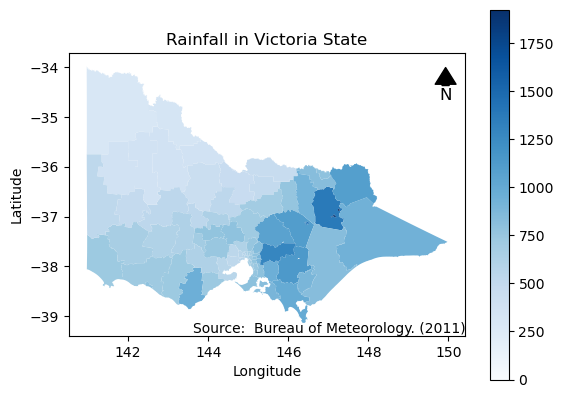

Top 10 LGAs with the most rainfall:
['Falls Creek Alpine Resort (Unincorporated)', 'Mount Hotham Alpine Resort (Unincorporated)', 'Mount Stirling Alpine Resort (Unincorporated)', 'Alpine Shire', 'Mount Buller Alpine Resort (Unincorporated)', 'Yarra Ranges Shire', 'Baw Baw Shire', 'Mansfield Shire', 'Towong Shire', 'Murrindindi Shire']


In [16]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
# victoria_state.plot(column = 'crash_count',cmap = 'Reds',legend=True)
ax = victoria_state.plot(column = 'rainfall',cmap = 'Blues', legend=True)

# Setting a blank background
ax.set_facecolor('white')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.text(1, 0, 'Source:  Bureau of Meteorology. (2011)', transform=ax.transAxes, 
        ha='right', va='bottom', fontsize=10)
plt.title('Rainfall in Victoria State')
x, y, arrow_length = 0.95, 0.95, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=12, xycoords=ax.transAxes)
plt.show()

victoria_state_sorted = victoria_state.sort_values(by='rainfall', ascending=False)
print('Top 10 LGAs with the most rainfall:')
print(list(victoria_state_sorted.head(10)['LGA_NAME']))

The statistics of rainfall:
count      92.000000
mean      685.632607
std       356.448874
min         0.000000
25%       539.835831
50%       698.447296
75%       817.761673
max      1924.864990
Name: rainfall, dtype: float64


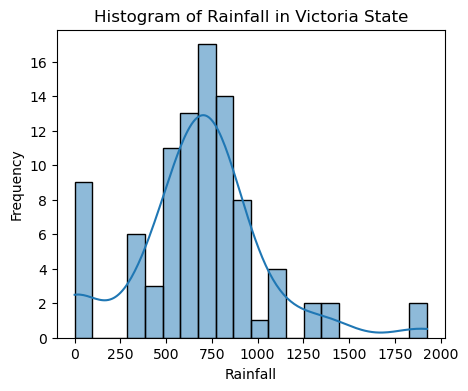

In [17]:
# Plot rainfall
import seaborn as sns
print('The statistics of rainfall:')
print(victoria_state['rainfall'].describe())

fig, ax = plt.subplots(1,1,figsize=(5, 4))
sns.histplot(victoria_state['rainfall'], bins=20, kde=True, ax=ax)
ax.set_title('Histogram of Rainfall in Victoria State')
ax.set_xlabel('Rainfall')
ax.set_ylabel('Frequency')
ax.set_facecolor('white')

plt.show()

The histogram of rainfall in Victoria shows the frequency distribution of annual rainfall amounts. Most of the regions have annual rainfall between 500 and 1000 millimetres, showing characteristics of a normal distribution with higher values in the middle and gradually decreasing towards the extremes. Few regions have very low rainfall (less than 250 millimetres) or very high rainfall (more than 1500 millimetres)s.

('WARNING: ', 4, ' is an island (no neighbors)')
('WARNING: ', 6, ' is an island (no neighbors)')
('WARNING: ', 23, ' is an island (no neighbors)')
('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 25, ' is an island (no neighbors)')
('WARNING: ', 26, ' is an island (no neighbors)')
Moran's I for rainfall:  0.43631312214292706
Expected I for rainfall:  -0.01098901098901099
p-value for rainfall:  0.001


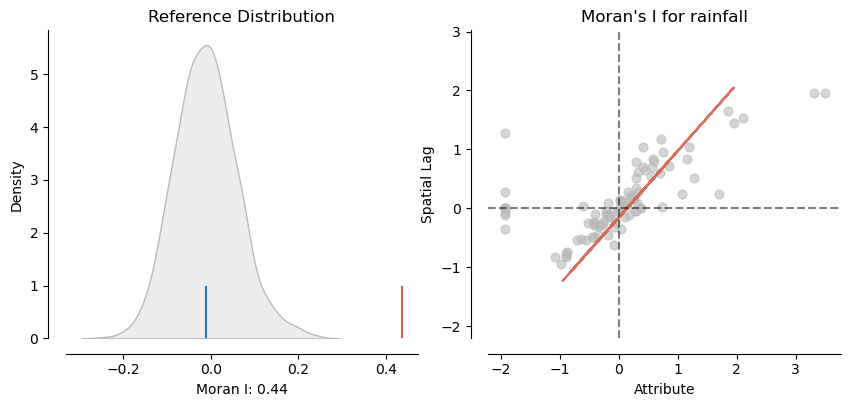

In [18]:
from splot.esda import plot_moran
from splot._viz_esda_mpl import plot_moran_simulation
# Create a spatial weights object
w = Queen.from_dataframe(victoria_state)

# Calculate Moran's I
moran_rainfall = Moran(victoria_state['rainfall'], w)

print('Moran\'s I for rainfall: ', moran_rainfall.I)
print('Expected I for rainfall: ', moran_rainfall.EI)
print('p-value for rainfall: ', moran_rainfall.p_sim)

plot_moran(moran_rainfall, zstandard=True)
plt.title('Moran\'s I for rainfall')
plt.show()


The analysis of rainfall in Victoria using Moran's I reveals significant spatial autocorrelation, with a Moran's I value of 0.436. This value is significantly higher than the expected value of -0.011, and the p-value of 0.001 indicates strong statistical significance. The reference distribution plot shows that the observed Moran's I value is far from what would be expected under a random distribution, indicating non-random spatial patterns.

The scatter plot of Moran's I for rainfall further proves that regions with high rainfall are more likely to be near other high-rainfall regions, and similarly, low-rainfall regions are clustered together. This suggests a clear geographic clustering of rainfall in Victoria, where areas with similar rainfall levels tend to be spatially close to one another.

## Analysis 1: Hot Spot Analysis (Getis-Ord Gi)
Hot Spot Analysis (Getis-Ord Gi*) [1] is a spatial statistical method used to identify clusters of high values (hot spots) or low values (cold spots) within a dataset. This technique helps in pinpointing areas with significant concentrations of certain phenomena, such as high crash rates, rainfall or severe accidents.  

By applying Hot Spot Analysis to the car crash data in Victoria, we can identify regions where rainfall and traffic accidents are particularly frequent or severe. We can then compare these plots to determine if there is any overlap, which may indicate a relationship between rainfall and traffic accidents. This information is crucial for traffic safety authorities as it allows for targeted interventions in areas with high accident concentrations.


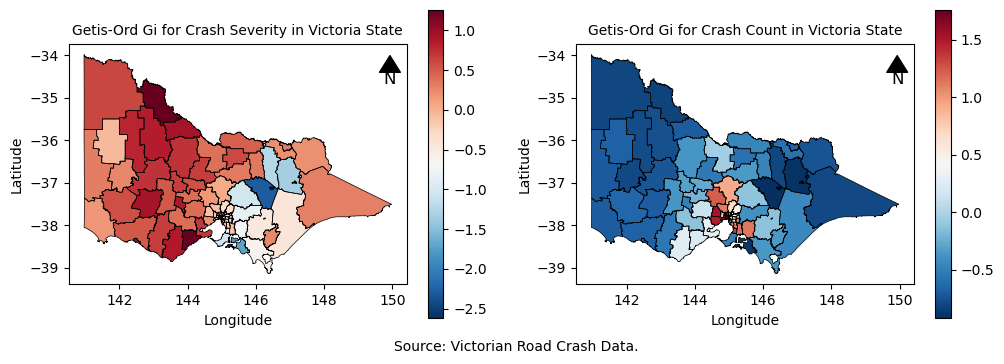

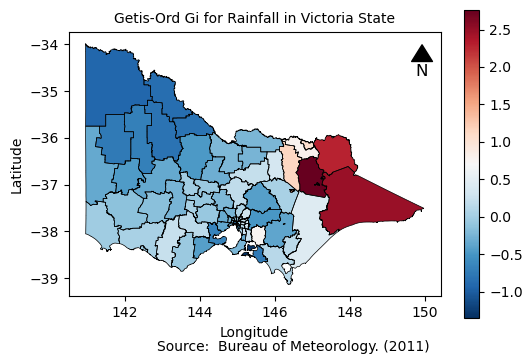

In [19]:
import matplotlib.pyplot as plt
from pysal.lib import weights
from esda.getisord import G_Local
from splot.esda import moran_scatterplot, plot_local_autocorrelation

# Assuming 'victoria_state' is a GeoDataFrame with the necessary columns like 'crash_severity', 'crash_count', and 'rainfall'

# Create a spatial weights object
w = weights.KNN.from_dataframe(victoria_state, k=4) # Choose an appropriate value for k
w.transform = 'r'

# Calculate Getis-Ord Gi for crash severity and crash count
victoria_state['gi_crash_severity'] = G_Local(victoria_state['crash_severity'], w).Zs
victoria_state['gi_crash_count'] = G_Local(victoria_state['crash_count']/12, w).Zs

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# First subplot for crash severity
victoria_state.plot(column='gi_crash_severity', cmap='RdBu_r', legend=True, ax=ax[0])
ax[0].set_title('Getis-Ord Gi for Crash Severity in Victoria State', fontsize=10, loc='center')
ax[0].set_facecolor('white')
victoria_state.boundary.plot(ax=ax[0], color='black', linewidth=0.5)
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')

# Second subplot for crash count
victoria_state.plot(column='gi_crash_count', cmap='RdBu_r', legend=True, ax=ax[1])
ax[1].set_title('Getis-Ord Gi for Crash Count in Victoria State', fontsize=10, loc='center')
ax[1].set_facecolor('white')
victoria_state.boundary.plot(ax=ax[1], color='black', linewidth=0.5)
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')
x, y, arrow_length = 0.95, 0.95, 0.1
# add north arrow 
ax[0].annotate('N', xy=(0.95, 0.95), xytext=(0.95, 0.85),
               arrowprops=dict(facecolor='black', width=5, headwidth=15),
               ha='center', va='center', fontsize=12, xycoords=ax[0].transAxes)

ax[1].annotate('N', xy=(0.95, 0.95), xytext=(0.95, 0.85),
               arrowprops=dict(facecolor='black', width=5, headwidth=15),
               ha='center', va='center', fontsize=12, xycoords=ax[1].transAxes)

fig.text(0.5, 0.02, 'Source: Victorian Road Crash Data. ', ha='center', va='bottom', fontsize=10)

plt.show()

w = weights.KNN.from_dataframe(victoria_state, k=4) # Using the same k-value
w.transform = 'r'
victoria_state['gi_rainfall'] = G_Local(victoria_state['rainfall']/12, w).Zs

# Plot for rainfall
fig, ax = plt.subplots(figsize=(6, 4))
victoria_state.plot(column='gi_rainfall', cmap='RdBu_r', legend=True, ax=ax)
ax.set_title('Getis-Ord Gi for Rainfall in Victoria State', fontsize=10, loc='center')
ax.set_facecolor('white')
victoria_state.boundary.plot(ax=ax, color='black', linewidth=0.5)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
x, y, arrow_length = 0.95, 0.95, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=12, xycoords=ax.transAxes)
fig.text(0.5, 0.02, 'Source:  Bureau of Meteorology. (2011)', ha='center', va='bottom', fontsize=10)
plt.show()



* Crash Severity: Regions in the northwest show high severity hot spots, indicating a need for focused safety measures.
* Crash Count: The central areas display significant hot spots for crash frequency, suggesting higher accident occurrences.
* Rainfall: The southeast region exhibits high rainfall hot spots, aligning with some areas of high crash severity and frequency. 

By loooking at the graphs above we see that the regions with highest rainfall doesn't have the highest car crashes or worst carsh severity. The reason for this might be due to higher traffic volume in central areas, leading to a higher crash count. Conversely, high speeds in the northwest regions might explain the higher severity of crashes. 

## Analysis 2: Geographically Weighted Regression (GWR)
Geographically Weighted Regression (GWR)[2] is a local regression technique that allows the relationships between variables to vary across space. It does this by fitting a regression model to the data near each observation point, capturing spatial differences. 

By applying GWR to our dataset, we can explore how the relationship between rainfall and traffic accidents changes across different regions in Victoria. This method helps us understand localized patterns and variations that may not be evident in a global model. For instance, GWR can reveal whether the impact of rainfall on traffic accidents is stronger in certain areas compared to others. This spatially explicit approach provides a more detailed understanding of the factors contributing to traffic accidents, enabling more effective and specific interventions.

In [20]:
import geopandas as gpd
import numpy as np
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
import matplotlib.pyplot as plt

# Calculate the centroid of each geometry in victoria_state
victoria_state['centroid'] = victoria_state['geometry'].centroid
# Extract the x and y coordinates of the centroids
victoria_state['x'] = victoria_state['centroid'].x
victoria_state['y'] = victoria_state['centroid'].y

# Create a list of coordinates from the x and y values
coords = list(zip(victoria_state['x'], victoria_state['y']))

# Prepare the independent variable (X) and dependent variable (y)
X = victoria_state[['rainfall']].values
y = victoria_state['crash_count'].values.reshape(-1, 1)
# Select the bandwidth for GWR
select = Sel_BW(coords,  y, X)
bw = select.search()

# Fit the GWR model with the selected bandwidth
gwr_model = GWR(coords, y, X, bw)
gwr_results = gwr_model.fit()

print(gwr_results.summary())

Model type                                                         Gaussian
Number of observations:                                                  92
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                        2927798.060
Log-likelihood:                                                    -607.469
AIC:                                                               1218.938
AICc:                                                              1221.211
BIC:                                                            2927391.099
R2:                                                                   0.003
Adj. R2:                                                             -0.009

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [21]:
import geopandas as gpd
import numpy as np
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
import matplotlib.pyplot as plt

# Calculate the centroid of each geometry in victoria_state
victoria_state['centroid'] = victoria_state['geometry'].centroid
# Extract the x and y coordinates of the centroids
victoria_state['x'] = victoria_state['centroid'].x
victoria_state['y'] = victoria_state['centroid'].y

# Create a list of coordinates from the x and y values
coords = list(zip(victoria_state['x'], victoria_state['y']))

# Prepare the independent variable (X) and dependent variable (y)
X = victoria_state[['rainfall']].values
y = victoria_state['crash_severity'].values.reshape(-1, 1)

# Select the bandwidth for GWR
select = Sel_BW(coords,  y, X)
bw = select.search()

# Fit the GWR model with the selected bandwidth
gwr_model = GWR(coords, y, X, bw)
gwr_results = gwr_model.fit()

print(gwr_results.summary())

Model type                                                         Gaussian
Number of observations:                                                  92
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            224.165
Log-likelihood:                                                    -171.510
AIC:                                                                347.019
AICc:                                                               349.292
BIC:                                                               -182.796
R2:                                                                   0.009
Adj. R2:                                                             -0.002

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

The Geographically Weighted Regression (GWR) analysis reveals significant spatial variations in the impact of rainfall variability on traffic accident frequency and severity across different LGAs in Victoria. 

For traffic accident frequency, the global regression model shows a weak explanatory power (R² = 0.003, adjusted R² = -0.009), and the p-value (0.634) indicates that the relationship is not significant at the global level. However, the GWR model significantly improves the explanatory power (R² = 0.504, adjusted R² = 0.433), suggesting that the impact of rainfall variability on traffic accident frequency varies significantly between LGAs. Some regions show a positive relationship while others show a negative or no significant impact. 

Similarly, for traffic accident severity, the global regression model also shows a weak explanatory power (R² = 0.009, adjusted R² = -0.002) with a non-significant p-value (0.376). The GWR model, however, significantly enhances the explanatory power (R² = 0.460, adjusted R² = 0.383), indicating that the effect of rainfall variability on traffic accident severity also varies across different LGAs. This localized analysis highlights the necessity for targeted interventions in specific areas where the relationship between rainfall and traffic accidents is more pronounced.

## Analysis 3: Spatial Error Model (SEM)
A Spatial Error Model (SEM)[3] is a type of spatial regression model specifically designed to handle spatial autocorrelation in the error terms. It addresses the spatial dependence by incorporating spatially lagged error terms into the model, thereby improving the accuracy of the estimates and inference.

In [22]:
import geopandas as gpd
import numpy as np
import spreg
# Create spatial weight matrix
# w = Queen.from_dataframe(victoria_state)
w = weights.KNN.from_dataframe(victoria_state, k=4)  # choose an appropriate value for k
w.transform = 'r'

# Prepare dependent and independent variables
X = victoria_state[['rainfall']].values
y = victoria_state['crash_count'].values.reshape(-1, 1)

# Fit Spatial Lag Model (SLM)
# slm = spreg.GM_Lag(y, X, w)
# print("Spatial Lag Model (SLM) results:\n", slm.summary)

# Fit Spatial Error Model (SEM)
sem = spreg.GM_Error(y, X, w, name_y='crash_count', name_x=['rainfall'])
print("Spatial Error Model (SEM) results:\n", sem.summary)

Spatial Error Model (SEM) results:
 REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: GM SPATIALLY WEIGHTED LEAST SQUARES
------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  : crash_count                Number of Observations:          92
Mean dependent var  :    162.9891                Number of Variables   :           2
S.D. dependent var  :    179.5961                Degrees of Freedom    :          90
Pseudo R-squared    :      0.0025

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT        96.28347        47.06869         2.04559         0.04080
            rainfall         0.09294         0.04584         2.02750         0.04261
              lambda         0.6

From the model summary we can see that the coefficient for the constant term is 96.28356, suggesting that in the absence of rainfall, the expected traffic accident frequency is 96.28347. This term is statistically significant with a p-value of 0.04080, which is less than 0.05.

The rainfall coefficient is 0.09294, indicating that for each unit increase in rainfall, the traffic accident frequency is expected to increase by 0.09294 units. This coefficient is also statistically significant, with a p-value of 0.04261, which is less than 0.05. This result shows that rainfall has a statistically significant impact on traffic accident frequency.

The spatial error coefficient (lambda) is 0.60338, suggesting moderate spatial dependence in the residuals. This value, being between 0 and 1, indicates that there is spatial autocorrelation in the model's error terms, which the SEM successfully accounts for.


In [23]:
import geopandas as gpd
import numpy as np
import spreg
# Create spatial weight matrix
w = weights.KNN.from_dataframe(victoria_state, k=4)  # choose an appropriate value for k
w.transform = 'r'

# Prepare dependent and independent variables
X = victoria_state[['rainfall']].values
y = victoria_state['crash_severity'].values.reshape(-1, 1)

# Fit Spatial Lag Model (SLM)
# slm = spreg.GM_Lag(y, X, w)
# print("Spatial Lag Model (SLM) results:\n", slm.summary)

# Fit Spatial Error Model (SEM)
sem = spreg.GM_Error(y, X, w, name_y='crash_severity', name_x=['rainfall'])
print("Spatial Error Model (SEM) results:\n", sem.summary)


Spatial Error Model (SEM) results:
 REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: GM SPATIALLY WEIGHTED LEAST SQUARES
------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :crash_severity                Number of Observations:          92
Mean dependent var  :      4.1221                Number of Variables   :           2
S.D. dependent var  :      1.5763                Degrees of Freedom    :          90
Pseudo R-squared    :      0.0086

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT         3.44374         0.41061         8.38684         0.00000
            rainfall         0.00119         0.00046         2.57452         0.01004
              lambda         0

The model summary indicates that the coefficient for the constant term is 3.44374, suggesting that in the absence of rainfall, the expected traffic accident severity is 3.44374. This term is statistically significant with a p-value of 0, which is less than 0.05.

The rainfall coefficient is 0.00119, indicating that for each unit increase in rainfall, the traffic accident severity is expected to increase by 0.00119 units. This coefficient is also statistically significant, with a p-value of 0.01004, which is less than 0.05. This result shows that rainfall has a statistically significant impact on traffic accident severity.

The spatial error coefficient (lambda) is 0.46102, suggesting moderate spatial dependence in the residuals. This value, being between 0 and 1, indicates that there is spatial autocorrelation in the model's error terms, which the SEM successfully accounts for.

Overall, the Spatial Error Model (SEM) results demonstrated that rainfall significantly impacts both traffic accident frequency and severity in Victoria. For traffic accident frequency, the positive rainfall coefficient indicates that higher rainfall leads to an increase in accident occurrences, with a statistically significant p-value confirming this relationship. Similarly, for traffic accident severity, the positive rainfall coefficient suggests that increased rainfall results in more severe accidents, also supported by a statistically significant p-value.

## Discussion

#### Insights from the Research
Our study aimed to explore the relationship between rainfall variability and traffic accidents in Victoria, focusing on both accident frequency and severity. The application of spatial analysis techniques, namely Geographically Weighted Regression (GWR), Spatial Error Model (SEM), and Hot Spot Analysis (Getis-Ord Gi), provided valuable insights into this relationship.

Hot Spot Analysis Results:
The Hot Spot Analysis identified specific regions where traffic accidents and rainfall are significantly higher or lower. The red areas on the maps indicate hot spots with higher accident severity, frequency, or rainfall, while the blue areas represent cold spots with lower values. These spatial clusters highlight areas that may require targeted traffic safety interventions. By comparing the moas we can see the southeast region exhibits high rainfall hot spots, aligning with some areas of high crash severity and frequency.

SEM Results:
The SEM results indicated that rainfall has a significant impact on both traffic accident frequency and severity. The SEM accounted for spatial autocorrelation, revealing moderate spatial dependence in the error terms. This indicates that areas with high rainfall tend to experience more frequent and severe accidents.

GWR Results:
The GWR results showed that the impact of rainfall on traffic accident frequency and severity varies across different regions. This local regression technique highlighted that while some areas exhibit a significant positive relationship between rainfall and accidents, other areas do not. This spatial variation underscores the importance of localized analysis in understanding the nuanced impacts of environmental factors on traffic safety.

Overall, we have identified specific regions where incident frequency and severity are most impacted by rainfall. The results from the SEM and GWR analyses provide further insights. SEM indicates that rainfall has a significant impact on both traffic accident frequency and severity, while GWR reveals that this impact varies across different regions and is not uniformly significant. These findings underscore the importance of considering both global and local variations when analyzing the relationship between rainfall and traffic accidents.



##### Strengths and Weaknesses of Techniques
***Hot Spot Analysis (Getis-Ord Gi):*** 

Strengths:
Hot Spor Analysis helps us identifies spatial clusters of high and low values, highlighting areas of concern.
Which is very useful for visualizing and understanding spatial patterns in the data.
However, it does not provide insights into the underlying causes of the observed patterns. 

***Geographically Weighted Regression (GWR):*** 

Strengths:
GWR is very good at captureing local heterogeneity, providing detailed insights into spatial variations. Identifies localized patterns and relationships that may not be found in global models.
However, GWR is computationally intensive, especially for large datasets and it may overfit the data in regions with fewer observations.

***Spatial Error Model (SEM):*** 

Strengths:
SEM accounts for global spatial autocorrelation, reducing bias in parameter estimates. It can provides a strong framework for understanding overall spatial effects.
However, SEM is less flexible in capturing local variations compared to GWR. Plus it will assumes uniform spatial dependence across the study area, potentially overlooking local heterogeneity. 

***Limitations***

All three techniques have their limitations. Hot Spot Analysis identifies clusters but does not explain why they occur. GWR may not always capture the complexity of spatial relationships and can be prone to overfitting. SEM, while effective in accounting for spatial autocorrelation, may miss local variations and assume uniform spatial dependence, which might not be realistic in heterogeneous environments. 

### Recommendations for Urban and Environmental Sustainability

As part of the University's commitment to sustainability, our study's findings highlight the need for targeted interventions to improve traffic safety in areas with high rainfall and accident rates. These interventions can be aligned with the UN Sustainable Development Goals (SDGs), particularly:

#### SDG 11: Sustainable Cities and Communities
- **Improve Infrastructure:** Develop and maintain infrastructure that is resilient to weather conditions. For example, enhance drainage systems and road surfaces to handle heavy rainfall, reducing the likelihood of accidents.
- **Smart Urban Planning:** Implement smart urban planning practices that consider environmental factors such as rainfall in traffic management and urban development.

#### SDG 3: Good Health and Well-being
- **Promote Road Safety:** Increase awareness and education on road safety during adverse weather conditions. Implement stricter regulations and enforcement to ensure safe driving practices.
- **Emergency Preparedness:** Enhance emergency response systems to quickly address traffic accidents, reducing the impact on public health.

#### SDG 13: Climate Action
- **Climate-Resilient Infrastructure:** Invest in climate-resilient infrastructure to mitigate the effects of extreme weather events. This includes designing roads and transportation systems that can withstand heavy rainfall and other climate-related impacts.
- **Data-Driven Policy Making:** Utilize data from spatial analysis to inform policy decisions related to urban planning, transportation, and environmental sustainability. Integrate climate data into traffic management systems to anticipate and respond to weather-related risks effectively.

#### Resilience Building
- **Adaptive Traffic Management:** We coould develop adaptive traffic management systems that can respond in real-time to changing weather conditions, improving safety and reducing accident risks.



### Conclusion

In conclusion, the analysis of the relationship between rainfall variability and traffic accidents in Victoria, using Hot Spot Analysis, Geographically Weighted Regression (GWR), and Spatial Error Model (SEM), has provided significant insights. To answer our research question ,the results we obtained indicate that rainfall significantly affects both the frequency and severity of traffic accidents, with spatial dependencies playing a crucial role. These findings somewhere align with our null hypothesis, where rainfall does have an influence on traffic accident frequency and severity. However, the area with the most rainfall doesn't have the highest accident frequency and the worst. We have identified specific areas for intervention through Hot Spot Analysis, while GWR and SEM revealed the importance of considering local variations and spatial autocorrelation.

To address these findings,  it is essential to implement infrastructure improvements, smart urban planning, and adaptive traffic management systems as we mentioned above. Aligning these efforts with the UN Sustainable Development Goals (SDGs) will enhance urban and environmental sustainability, improve public health, and build resilience against climate-related impacts. By leveraging data-driven policymaking, we can create safer, more sustainable urban environments in Victoria and beyond.

## Reference
[1]Khan, G., Qin, X., & Noyce, D. A. (2008). Spatial Analysis of Weather Crash Patterns. Journal of Transportation Engineering, 134(5), 191–202. https://doi.org/10.1061/(asce)0733-947x(2008)134:5(191)  (Khan et al., 2008)

[2]Wan. (2018). The spatial analysis of crash frequency and injury severities in New York City: Applications of geographically weighted regression method. The Spatial Analysis of Crash Frequency and Injury Severities in New York City: Applications of Geographically Weighted Regression Method - ProQuest. https://www.proquest.com/openview/1e14427e949597cb9474758750e8250d/1?pq-origsite=gscholar&cbl=18750 

[3]Rinaldi, A., Susianto, Y., Santoso, B., & Kusumaningtyas, W. (2021). Spatial modeling for poverty: The comparison of spatial error model and geographic weighted regression. Al-Jabar: Jurnal Pendidikan Matematika, 12(1), 237-251. http://ejournal.radenintan.ac.id/index.php/al-jabar/index

Victorian Road Crash Data. (n.d.). Vicroads Open Data-Vicroads Maps.open data.arcgis.com. https://vicroadsopendata-vicroadsmaps.opendata.arcgis.com/datasets/vicroadsmaps::victorian-road-crash-data/about

Bureau of Meteorology. (2011). Rainfall data information - Bureau of Meteorology. Bom.gov.au. http://www.bom.gov.au/climate/cdo/about/cdo-rainfall-feature.shtml

Search. (n.d.). Data.gov.au. https://data.gov.au/dataset/ds-dga-bdf92691-c6fe-42b9-a0e2-a4cd716fa811/details